In [304]:
import pandas as pd
import numpy  as np

import data file

In [305]:
df = pd.read_csv('data_new.csv')
df.describe()

,Label
count,329.000000
mean,0.589666
std,0.492644
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


split data

In [306]:
print("Non-cheat: ", len(df[df['Label']==0]))
print("Cheat: ", len(df[df['Label']==1]))

# diff = abs(len(df[df['Label']==0]) - len(df[df['Label']==1]))

grouped = df.groupby(df.Label)
df1 = grouped.get_group(1)
df2 = grouped.get_group(0)

df2_1 = df.iloc[:135,:]
df2_2 = df.iloc[135:194,:]

df1_train = df1.iloc[:111,:]
df2_train = df2_1.iloc[:111,:]

df1_test = df1.iloc[111:135,:]
df2_test = df2_1.iloc[111:135,:]

train = pd.concat([df1_train, df2_train])
test  = pd.concat([df1_test, df2_test, df2_2])

print((len(train), len(test)))

Non-cheat:  135
Cheat:  194
(222, 107)


parse data from string to numpy array

In [307]:
def parseData(series):
    final_series = []
    for ser in series:
        temp = []
        for x in "[],":
            ser = ser.replace(x, "")
        new_ser  = np.fromstring(ser, dtype=float, sep=" ")
        for i in range(0, len(new_ser), 3):
            chunk = [new_ser[i], new_ser[i + 1], new_ser[i + 2]]
            temp.append(chunk)
        final_series.append(temp)
    return np.array(final_series, dtype=object)

get the longest sequence of vector in dataset

In [308]:
max_length = 0
for lgaze in parseData(df['Left Gaze']):
    if len(lgaze) > max_length:
        max_length = len(lgaze)
        
max_length

1294

pad the dataset to the longest sequence size

In [309]:
import math

def padData(series, length):
    for idx, ser in enumerate(series):
        times = math.floor(length / len(ser))
        add = length % len(ser)
        
        temp = ser[::-1]
        for _ in range(1, times):
            series[idx] = np.append(series[idx], temp, axis=0)
            temp = temp[::-1]
        if add != 0:
            series[idx] = np.append(series[idx], temp[0:add], axis=0)
    return series

Conv1D -> AveragePooling1D -> Conv1D -> AveragePooling1D -> LSTM -> Dense

In [310]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, AveragePooling1D, LSTM, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, History

import tensorflow as tf

def init_model(): 
        alexnet = Sequential()
        alexnet.add(Conv1D(filters=96, kernel_size=11, padding='same', strides=4, activation='relu', input_shape=(max_length,12)))
        alexnet.add(AveragePooling1D(pool_size=3, strides=2, padding='same'))
        alexnet.add(Conv1D(filters=256, kernel_size=5, padding='same', activation='relu'))
        alexnet.add(AveragePooling1D(pool_size=3, strides=2))
        alexnet.add(Conv1D(filters=384, kernel_size=3, padding='same', activation='relu'))
        alexnet.add(Conv1D(filters=384, kernel_size=3, padding='same', activation='relu'))
        alexnet.add(Conv1D(filters=256, kernel_size=3, padding='same', activation='relu'))
        alexnet.add(AveragePooling1D(pool_size=3, strides=2))
        alexnet.add(LSTM(256))
        alexnet.add(Flatten())

        # Fully connected layers
        alexnet.add(Dense(units=8, activation='relu'))
        alexnet.add(Dropout(0.5))
        alexnet.add(Dense(units=8, activation='relu'))
        alexnet.add(Dropout(0.5))

        alexnet.add(Dense(units=2, activation='softmax'))
        
        adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
        alexnet.compile(optimizer=adam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

        return alexnet


In [311]:
right_gaze_train = train["Right Gaze"]
left_gaze_train  = train["Left Gaze"]
right_head_train = train["Right HeadPose"]
left_head_train  = train["Left HeadPose"]

label_train = train['Label']

right_gaze_train, left_gaze_train, right_head_train, left_head_train = parseData(right_gaze_train), parseData(left_gaze_train), parseData(right_head_train), parseData(left_head_train)

initialize new data frame

In [312]:
left_head_train  = padData(left_head_train,  max_length)
right_head_train = padData(right_head_train, max_length)
left_gaze_train  = padData(left_gaze_train,  max_length)
right_gaze_train = padData(right_gaze_train, max_length)

In [313]:
label_train = np.array(label_train)

In [314]:
y_train = []
for i in range(len(label_train)):
    y_train.append(
        tf.convert_to_tensor(
            np.reshape(tf.keras.utils.to_categorical(label_train[i], num_classes=2), (1, 2))                 
                            )
             )
    
y_train = tf.convert_to_tensor(np.vstack(y_train), dtype=tf.float32)

In [ ]:
def normalize(data, a, b):
    # Reshape the data to work on each feature separately
    reshaped_data = tf.reshape(data, (-1, data.shape[-1]))

    # Calculate min and max values for each feature
    min_vals = tf.reduce_min(reshaped_data, axis=0)
    max_vals = tf.reduce_max(reshaped_data, axis=0)

    # Normalize to range [a, b]
    normalized_data = (b - a) * (reshaped_data - min_vals) / (max_vals - min_vals + 1e-8) + a
    
    # Reshape back to the original shape
    normalized_data = tf.reshape(normalized_data, data.shape)

    return normalized_data

In [315]:
x_train = []

for i in range(len(left_gaze_train)):
    x_train.append(tf.convert_to_tensor([
                                            np.hstack(
                                                        (left_gaze_train[i], right_gaze_train[i], left_head_train[i], right_head_train[i])
                                                     )
                                            ], dtype=tf.float32))



x_train = tf.convert_to_tensor(np.vstack(x_train), dtype=tf.float32)

x_train = normalize(x_train, -5, 5)

print(x_train)

print(y_train)

tf.Tensor(
[[[  8.705  28.278  29.588 ...   1.558   2.732   3.145]
  [ -0.833  30.56  -30.571 ... -10.108   5.971 -11.741]
  [ -3.198  34.952 -35.098 ... -10.394   8.097 -13.176]
  ...
  [ -9.057  41.776 -42.746 ... -13.675  13.786 -19.418]
  [-16.372  28.36  -32.746 ... -12.991   8.778 -15.678]
  [-19.187  29.768 -35.416 ... -14.631   9.291 -17.332]]

 [[ 22.966  10.843  25.397 ...  30.359  -4.118  30.637]
  [  5.671  15.266  16.285 ...  18.896  -1.472  18.953]
  [  3.35   10.455  10.978 ...  -1.709   5.526  -5.784]
  ...
  [ -1.252  12.933 -12.994 ...   6.863   0.745   6.903]
  [ -3.019  14.169 -14.487 ...   9.237   2.032   9.458]
  [  7.474   5.718   9.41  ...   2.513   7.471   7.882]]

 [[ 27.556  25.147  37.306 ...  17.437  34.229  38.415]
  [ 20.462  44.667  49.131 ...   2.079  50.654  50.697]
  [ 15.712  58.805  60.868 ...  -3.587  62.252 -62.355]
  ...
  [ -0.803  48.756 -48.762 ... -18.131  46.641 -50.041]
  [ -0.776  49.995 -50.001 ... -18.296  47.122 -50.549]
  [ -4.184  49.

Train the model

In [316]:
model = init_model()
# callbacks = [EarlyStopping(monitor='loss', patience=3), History()]
callbacks = [History()]
history = model.fit(x_train, y_train, epochs=200, batch_size=64, callbacks=callbacks)

Epoch 1/200


e:\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


4/4 [==============================] - 4s 277ms/step - loss: 0.7581 - accuracy: 0.6486
Epoch 2/200
4/4 [==============================] - 1s 249ms/step - loss: 0.5571 - accuracy: 0.7928
Epoch 3/200
4/4 [==============================] - 1s 254ms/step - loss: 0.6259 - accuracy: 0.8018
Epoch 4/200
4/4 [==============================] - 1s 243ms/step - loss: 0.5655 - accuracy: 0.8018
Epoch 5/200
4/4 [==============================] - 1s 250ms/step - loss: 0.5457 - accuracy: 0.8018
Epoch 6/200
4/4 [==============================] - 1s 253ms/step - loss: 0.5359 - accuracy: 0.8018
Epoch 7/200
4/4 [==============================] - 1s 344ms/step - loss: 0.5418 - accuracy: 0.8018
Epoch 8/200
4/4 [==============================] - 2s 362ms/step - loss: 0.5126 - accuracy: 0.8018
Epoch 9/200
4/4 [==============================] - 2s 373ms/step - loss: 0.5118 - accuracy: 0.8018
Epoch 10/200
4/4 [==============================] - 1s 365ms/step - loss: 0.5185 - accuracy: 0.8018
Epoch 11/200
4/4 [===

In [317]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_76 (Conv1D)          (None, 324, 96)           12768     
                                                                 
 average_pooling1d_45 (Avera  (None, 162, 96)          0         
 gePooling1D)                                                    
                                                                 
 conv1d_77 (Conv1D)          (None, 162, 256)          123136    
                                                                 
 average_pooling1d_46 (Avera  (None, 80, 256)          0         
 gePooling1D)                                                    
                                                                 
 conv1d_78 (Conv1D)          (None, 80, 384)           295296    
                                                                 
 conv1d_79 (Conv1D)          (None, 80, 384)         

Predict test set

In [318]:
right_gaze_test = test["Right Gaze"]
left_gaze_test  = test["Left Gaze"]
right_head_test = test["Right HeadPose"]
left_head_test  = test["Left HeadPose"]

label_test = test['Label']

right_gaze_test, left_gaze_test, right_head_test, left_head_test = parseData(right_gaze_test), parseData(left_gaze_test), parseData(right_head_test), parseData(left_head_test)

In [319]:
left_head_test  = padData(left_head_test,  max_length)
right_head_test = padData(right_head_test, max_length)
left_gaze_test  = padData(left_gaze_test,  max_length)
right_gaze_test = padData(right_gaze_test, max_length)

In [320]:
x_test = []

for i in range(len(left_gaze_test)):
    x_test.append(tf.convert_to_tensor([
                                            np.hstack(
                                                        (left_gaze_test[i], right_gaze_test[i], left_head_test[i], right_head_test[i])
                                                     )
                                            ], dtype=tf.float32))



x_test = tf.convert_to_tensor(np.vstack(x_test), dtype=tf.float32)

print(x_test)

tf.Tensor(
[[[ 51.537  30.285  59.777 ...  53.407   8.105  54.019]
  [ 40.51   37.984  55.533 ...  48.782   6.237  49.179]
  [ 26.477  32.743  42.108 ...  41.713  14.326  44.104]
  ...
  [  9.333  36.422  37.598 ...  32.341  15.118  35.7  ]
  [ 32.112  34.174  46.894 ...  47.997  12.341  49.559]
  [ 25.442  29.643  39.064 ...  41.91    9.913  43.066]]

 [[ 29.547  18.415  34.815 ...  44.61    5.529  44.951]
  [ 28.973  18.207  34.219 ...  43.922   4.782  44.182]
  [ 43.92   15.941  46.724 ...  48.461   1.124  48.474]
  ...
  [ 39.393   9.628  40.552 ...  41.659  -5.382  42.005]
  [ 35.149  10.188  36.595 ...  47.753  -4.01   47.921]
  [ 38.596   9.017  39.635 ...  49.893  -5.698  50.217]]

 [[-16.954  73.426 -75.358 ... -26.907  60.171 -65.913]
  [-22.978  82.974 -86.096 ... -32.98   67.892 -75.478]
  [-39.21   73.834 -83.599 ... -38.416  60.714 -71.847]
  ...
  [-30.736  50.905 -59.464 ... -21.113  18.457 -28.043]
  [-56.668  55.566 -79.366 ... -48.625  30.22  -57.251]
  [-43.283  75.

In [321]:
predictions = model.predict(x_test)

label_predictions = []

# convert from category to label
for prediction in predictions:
    if prediction[0] > prediction[1]:
        label_predictions.append(0)
    else: label_predictions.append(1)
    
label_predictions = np.array(label_predictions)
label_test = np.array(label_test)

print(label_predictions)
print(label_test)

# calc acc
true_count = 0
for idx, label in enumerate(label_predictions):
    if label == label_test[idx]:
        true_count += 1
        
print("Accuracy on test set: ", true_count/(len(label_test)))

4/4 [==============================] - 1s 75ms/step
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 1 0 1 0
 0 0 1 1 0 0 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 1 0 1 1 1 1
 1 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 0 1 0 1 0 0]
Accuracy on test set:  0.6915887850467289


In [322]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


In [323]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

plot the loss and acc from training process

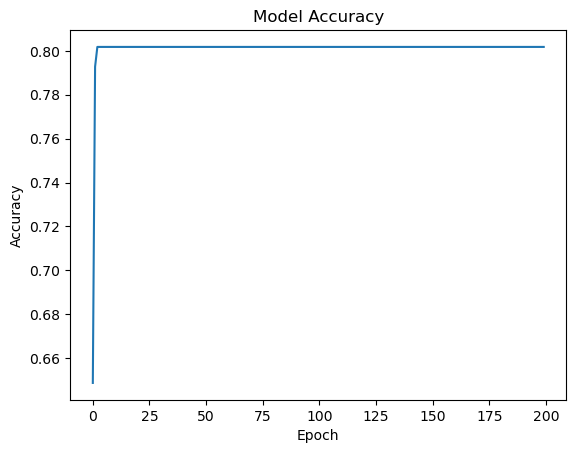

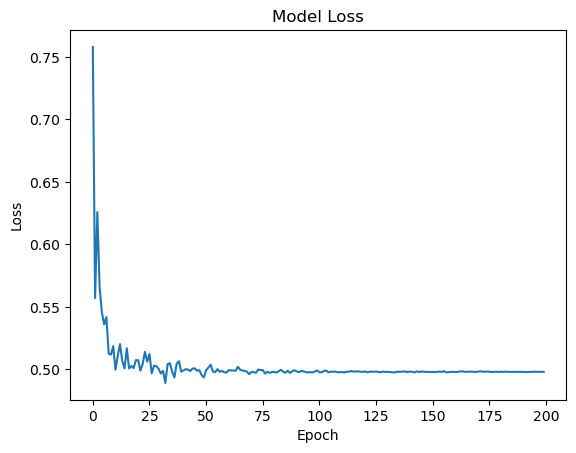

In [324]:
from matplotlib import pyplot as plt
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [325]:
model.save('GP043.keras')